### Importing necessary libraries

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Loading data

In [2]:
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

### Preprocessing

#### Splitting train set to images and labels

In [3]:
train_labels = df_train['label'].values
train_data = df_train.values[:, 1:]

In [4]:
len(train_labels)

42000

#### Scaling

In [5]:
train_scaled = train_data / 255
test_scaled = df_test.values / 255

#### reshaping

In [6]:
image_size = 28

train_images = train_scaled.reshape(df_train.shape[0], image_size, image_size, 1)
test_images = test_scaled.reshape(df_test.shape[0], image_size, image_size, 1)

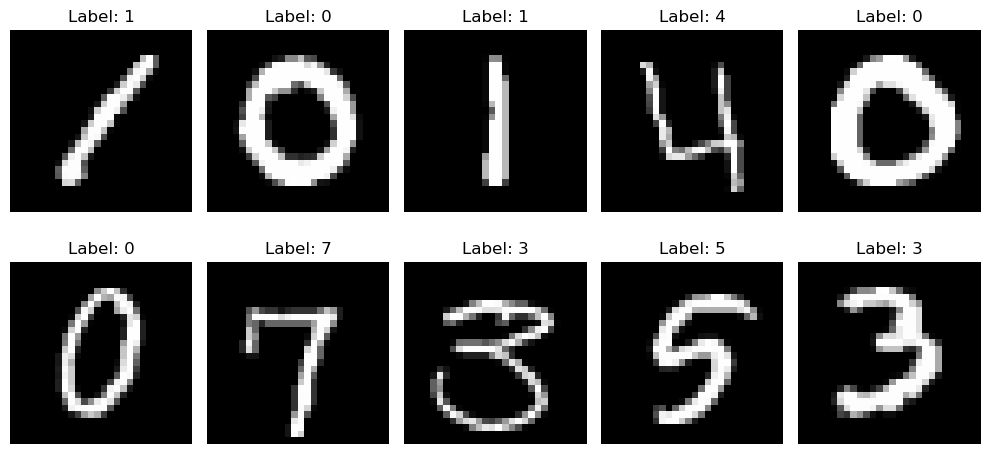

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10): 
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### train and validation set

In [8]:
 X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

### Building CNN

In [9]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid'),
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0

In [10]:
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)
datagen.fit(X_train)
augmented_data_generator = datagen.flow(X_train, y_train, batch_size=64)

In [12]:
history = model.fit(
    augmented_data_generator,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=16,
    callbacks=[es]
)

Epoch 1/60
525/525 [==============================] - 22s 39ms/step - loss: 1.5137 - accuracy: 0.4787 - val_loss: 0.6885 - val_accuracy: 0.8242
Epoch 2/60
525/525 [==============================] - 21s 39ms/step - loss: 0.7518 - accuracy: 0.7498 - val_loss: 0.1829 - val_accuracy: 0.9448
Epoch 3/60
525/525 [==============================] - 20s 39ms/step - loss: 0.5199 - accuracy: 0.8328 - val_loss: 0.1364 - val_accuracy: 0.9573
Epoch 4/60
525/525 [==============================] - 21s 39ms/step - loss: 0.4342 - accuracy: 0.8605 - val_loss: 0.1188 - val_accuracy: 0.9627
Epoch 5/60
525/525 [==============================] - 20s 39ms/step - loss: 0.3863 - accuracy: 0.8760 - val_loss: 0.1126 - val_accuracy: 0.9643
Epoch 6/60
525/525 [==============================] - 20s 38ms/step - loss: 0.3578 - accuracy: 0.8860 - val_loss: 0.1017 - val_accuracy: 0.9694
Epoch 7/60
525/525 [==============================] - 19s 37ms/step - loss: 0.3312 - accuracy: 0.8942 - val_loss: 0.1021 - val_accuracy:

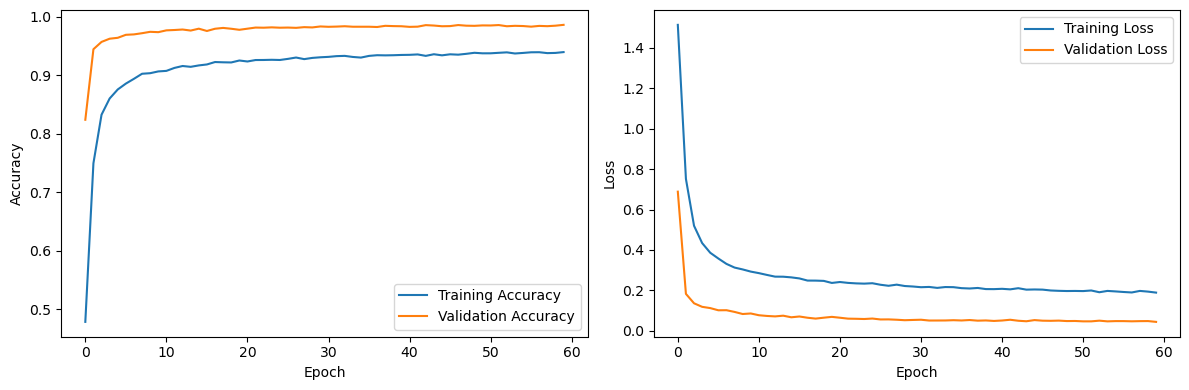

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
predictions = pd.DataFrame({
    'ImageId': np.arange(1, len(test_images) + 1),
    'Label': np.argmax(
        model.predict(test_images),
        axis=1
    )}
).set_index('ImageId')
predictions

875/875 [==============================] - 5s 5ms/step


,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
...,...
27996,9
27997,7
27998,3


In [15]:
predictions.to_csv('/kaggle/working/pred.csv')